<!-- # # Projet : Prédiction des Réservations Clients
# 
# ## Objectif
# L'objectif de ce projet est de prédire si un client effectuera une réservation (`booking_complete = 1`) ou non (`booking_complete = 0`) en utilisant un modèle de machine learning. Nous allons explorer le jeu de données, préparer les données, entraîner un modèle, et évaluer ses performances.

# ## 1. Importation des Bibliothèques
# Nous commençons par importer les bibliothèques nécessaires.

# %% -->

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, recall_score, roc_auc_score
from imblearn.over_sampling import SMOTE, ADASYN
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import joblib

 ## 2. Chargement des Données
# Nous chargeons le jeu de données et examinons les premières lignes pour comprendre sa structure.


In [14]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")

# Afficher les premières lignes
print("Aperçu des données :")
df.head()

Aperçu des données :


,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


## 3. Exploration des Données
# Nous explorons les données pour comprendre les variables et détecter d'éventuels problèmes.




Informations sur le jeu de données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), i

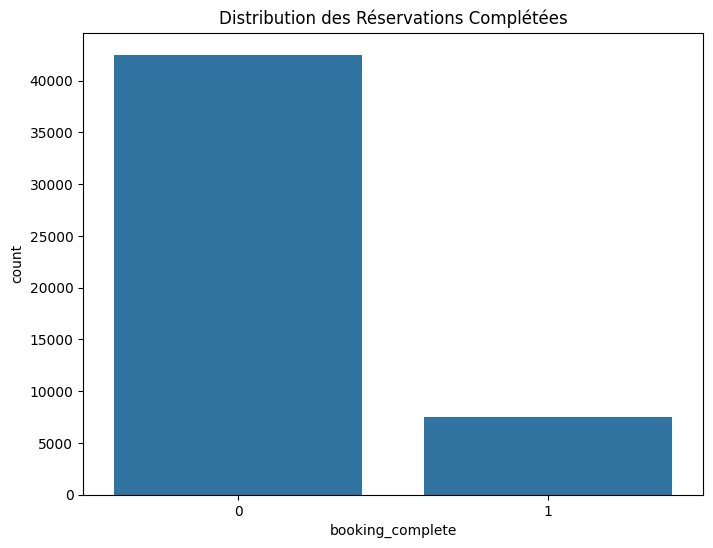

In [15]:
# Informations générales sur le jeu de données
print("\nInformations sur le jeu de données :")
df.info()

# Statistiques descriptives
print("\nStatistiques descriptives :")
print(df.describe())

# Vérifier les valeurs manquantes
print("\nValeurs manquantes par colonne :")
print(df.isnull().sum())

# Distribution de la variable cible
plt.figure(figsize=(8, 6))
sns.countplot(x='booking_complete', data=df)
plt.title('Distribution des Réservations Complétées')
plt.show()

 ## 4. Préparation des Données
# Nous préparons les données pour l'entraînement du modèle en gérant les variables catégorielles et en divisant le jeu de données.



In [31]:
# Conversion de flight_day en valeurs numériques
day_mapping = {
    'Mon': 0,
    'Tue': 1,
    'Wed': 2,
    'Thu': 3,
    'Fri': 4,
    'Sat': 5,
    'Sun': 6
}
df['flight_day'] = df['flight_day'].map(day_mapping)

# Encodage des variables catégorielles
# One-Hot Encoding pour les variables nominales
df_encoded = pd.get_dummies(df, columns=['sales_channel', 'trip_type', 'route', 'booking_origin'], drop_first=True)

# Afficher les premières lignes après encodage
print("\nAperçu des données après encodage :")
df_encoded.head()

# Vérifier les types de données après conversion
print("\nInformations sur les données après encodage :")
df_encoded.info()


Aperçu des données après encodage :

Informations sur les données après encodage :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 914 entries, num_passengers to booking_origin_Vietnam
dtypes: bool(904), float64(2), int64(8)
memory usage: 46.9 MB


 ## 5. Division des Données
# Nous divisons les données en ensembles d'entraînement et de test.



In [17]:
# Séparer les features (X) et la target (y)
X = df_encoded.drop('booking_complete', axis=1)
y = df_encoded['booking_complete']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTaille de l'ensemble d'entraînement : {X_train.shape}")
print(f"Taille de l'ensemble de test : {X_test.shape}")


Taille de l'ensemble d'entraînement : (40000, 913)
Taille de l'ensemble de test : (10000, 913)


 ## 6. Gestion du Déséquilibre des Classes
# Le jeu de données est déséquilibré. Nous utilisons SMOTE pour rééquilibrer les classes.



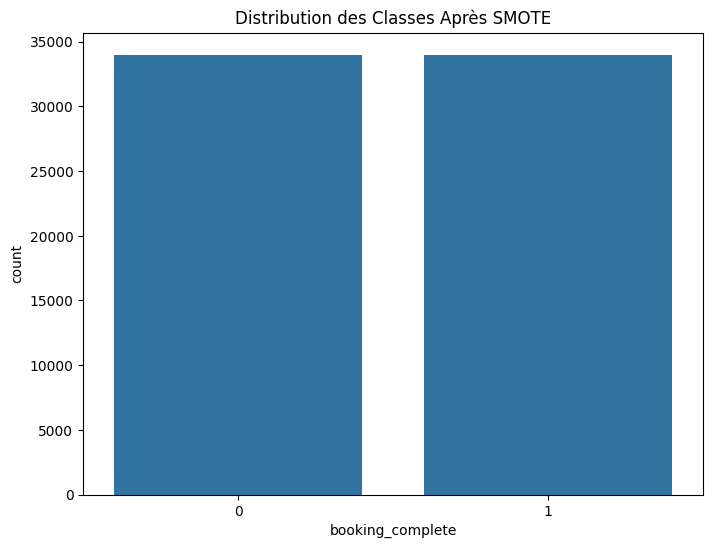

In [18]:
# Appliquer SMOTE pour rééquilibrer les classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Vérifier la nouvelle distribution des classes
plt.figure(figsize=(8, 6))
sns.countplot(x=y_resampled)
plt.title('Distribution des Classes Après SMOTE')
plt.show()


 ## 7. Entraînement du Modèle (RandomForest)
# Nous entraînons un modèle RandomForestClassifier sur les données rééquilibrées.



In [19]:
# Initialiser le modèle
model_rf = RandomForestClassifier(random_state=42)

# Entraîner le modèle sur les données rééquilibrées
model_rf.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

 ## 8. Évaluation du Modèle (RandomForest)
# Nous évaluons le modèle en utilisant l'ensemble de test.



Accuracy (RandomForest) : 0.8435

Rapport de Classification (RandomForest) :
               precision    recall  f1-score   support

           0       0.88      0.95      0.91      8520
           1       0.45      0.23      0.31      1480

    accuracy                           0.84     10000
   macro avg       0.66      0.59      0.61     10000
weighted avg       0.81      0.84      0.82     10000



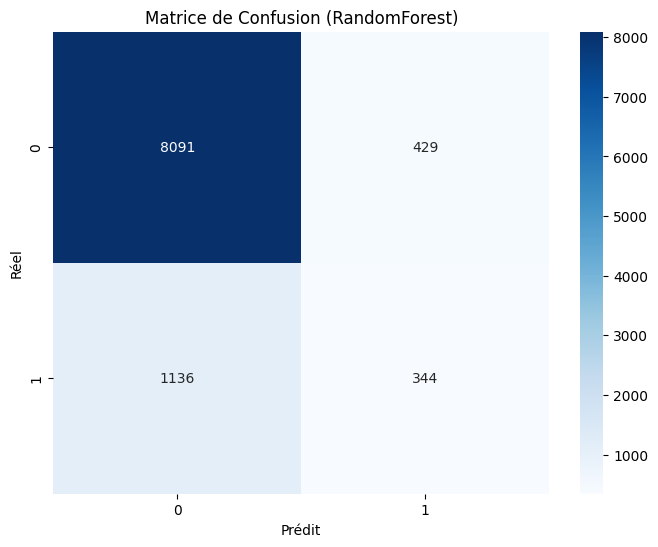

In [20]:
# Prédictions sur l'ensemble de test
y_pred_rf = model_rf.predict(X_test)

# Calcul de l'accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy (RandomForest) : {accuracy_rf:.4f}")

# Rapport de classification
print("\nRapport de Classification (RandomForest) :\n", classification_report(y_test, y_pred_rf))

# Matrice de confusion
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de Confusion (RandomForest)')
plt.show()

 ## 9. Importance des Variables (RandomForest)
# Nous visualisons l'importance des variables pour comprendre leur contribution au modèle.


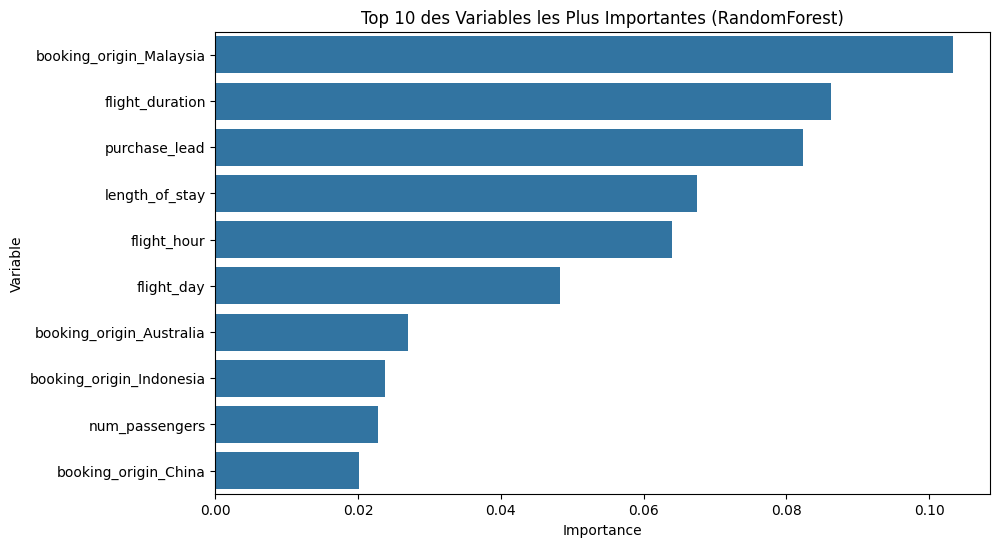

In [21]:
# Obtenir l'importance des variables
importances = model_rf.feature_importances_
feature_names = X.columns

# Créer un DataFrame pour la visualisation
feature_importance_df = pd.DataFrame({'Variable': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Afficher les 10 variables les plus importantes
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Variable', data=feature_importance_df.head(10))
plt.title('Top 10 des Variables les Plus Importantes (RandomForest)')
plt.show()


 ## 10. Amélioration du Modèle (RandomForest avec GridSearchCV)
# Nous ajustons les hyperparamètres pour améliorer le modèle.



In [22]:
# Ajuster les hyperparamètres du modèle
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'class_weight': [{0: 1, 1: 2}, {0: 1, 1: 5}]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='f1')
grid_search.fit(X_resampled, y_resampled)

# Meilleurs hyperparamètres
print("Meilleurs hyperparamètres (RandomForest) :", grid_search.best_params_)

# Entraîner le modèle avec les meilleurs hyperparamètres
best_model_rf = grid_search.best_estimator_
best_model_rf.fit(X_resampled, y_resampled)

# Évaluer le modèle ajusté
y_pred_rf_tuned = best_model_rf.predict(X_test)
print("\nRapport de Classification (RandomForest Ajusté) :\n", classification_report(y_test, y_pred_rf_tuned))

Meilleurs hyperparamètres (RandomForest) : {'class_weight': {0: 1, 1: 2}, 'max_depth': 20, 'n_estimators': 200}

Rapport de Classification (RandomForest Ajusté) :
               precision    recall  f1-score   support

           0       0.95      0.54      0.68      8520
           1       0.24      0.82      0.37      1480

    accuracy                           0.58     10000
   macro avg       0.59      0.68      0.53     10000
weighted avg       0.84      0.58      0.64     10000




 ## 11. Essayer un Autre Algorithme (XGBoost)
# Nous essayons XGBoost pour voir s'il performe mieux sur ce jeu de données.


In [23]:
# Initialiser et entraîner un modèle XGBoost
model_xgb = XGBClassifier(
    scale_pos_weight=5,  # Ajuster en fonction du déséquilibre des classes
    max_depth=10,        # Limiter la profondeur des arbres
    learning_rate=0.1,   # Réduire le taux d'apprentissage
    random_state=42
)
model_xgb.fit(X_resampled, y_resampled)

# Prédictions avec XGBoost
y_pred_xgb = model_xgb.predict(X_test)

# Évaluer XGBoost
print("\nRapport de Classification (XGBoost) :\n", classification_report(y_test, y_pred_xgb))

# Calculer l'AUC-ROC
y_pred_proba_xgb = model_xgb.predict_proba(X_test)[:, 1]
auc_roc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print(f"AUC-ROC (XGBoost) : {auc_roc_xgb:.4f}")


Rapport de Classification (XGBoost) :
               precision    recall  f1-score   support

           0       0.94      0.66      0.77      8520
           1       0.28      0.77      0.41      1480

    accuracy                           0.67     10000
   macro avg       0.61      0.71      0.59     10000
weighted avg       0.84      0.67      0.72     10000

AUC-ROC (XGBoost) : 0.7724


 ## 12. Essayer un Autre Algorithme (LightGBM)
# Nous essayons LightGBM pour voir s'il performe mieux sur ce jeu de données.



In [24]:
# Initialiser et entraîner un modèle LightGBM
model_lgbm = LGBMClassifier(
    scale_pos_weight=5,  # Ajuster en fonction du déséquilibre des classes
    max_depth=10,        # Limiter la profondeur des arbres
    learning_rate=0.1,   # Réduire le taux d'apprentissage
    random_state=42
)
model_lgbm.fit(X_resampled, y_resampled)

# Prédictions avec LightGBM
y_pred_lgbm = model_lgbm.predict(X_test)

# Évaluer LightGBM
print("\nRapport de Classification (LightGBM) :\n", classification_report(y_test, y_pred_lgbm))

# Calculer l'AUC-ROC
y_pred_proba_lgbm = model_lgbm.predict_proba(X_test)[:, 1]
auc_roc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)
print(f"AUC-ROC (LightGBM) : {auc_roc_lgbm:.4f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 34002, number of negative: 34002
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1861
[LightGBM] [Info] Number of data points in the train set: 68004, number of used features: 534
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Rapport de Classification (LightGBM) :
               precision    recall  f1-score   support

           0       0.95      0.61      0.74      8520
           1       0.27      0.82      0.40      1480

    accuracy                           0.64     10000
   macro avg       0.61      0.72      0.57     10000
weighted avg       0.85      0.64      0.69     10000

AUC-ROC (LightGBM) : 0.7706


 ## 13. Essayer un Autre Algorithme (CatBoost)
# Nous essayons CatBoost pour voir s'il performe mieux sur ce jeu de données.



In [25]:
# Initialiser et entraîner un modèle CatBoost
model_catboost = CatBoostClassifier(
    scale_pos_weight=5,  # Ajuster en fonction du déséquilibre des classes
    random_state=42,
    verbose=0
)
model_catboost.fit(X_resampled, y_resampled)

# Prédictions avec CatBoost
y_pred_catboost = model_catboost.predict(X_test)

# Évaluer CatBoost
print("\nRapport de Classification (CatBoost) :\n", classification_report(y_test, y_pred_catboost))

# Calculer l'AUC-ROC
y_pred_proba_catboost = model_catboost.predict_proba(X_test)[:, 1]
auc_roc_catboost = roc_auc_score(y_test, y_pred_proba_catboost)
print(f"AUC-ROC (CatBoost) : {auc_roc_catboost:.4f}")


Rapport de Classification (CatBoost) :
               precision    recall  f1-score   support

           0       0.95      0.64      0.76      8520
           1       0.28      0.79      0.41      1480

    accuracy                           0.66     10000
   macro avg       0.61      0.72      0.59     10000
weighted avg       0.85      0.66      0.71     10000

AUC-ROC (CatBoost) : 0.7839


 ## 14. Essayer une Technique de Rééchantillonnage Avancée (ADASYN)
# Nous essayons ADASYN pour améliorer le rééquilibrage des classes.



In [26]:

# Appliquer ADASYN pour rééquilibrer les classes
adasyn = ADASYN(random_state=42)
X_resampled_adasyn, y_resampled_adasyn = adasyn.fit_resample(X_train, y_train)

# Entraîner un modèle RandomForest sur les données rééquilibrées avec ADASYN
model_rf_adasyn = RandomForestClassifier(random_state=42)
model_rf_adasyn.fit(X_resampled_adasyn, y_resampled_adasyn)

# Prédictions avec ADASYN
y_pred_adasyn = model_rf_adasyn.predict(X_test)

# Évaluer ADASYN
print("\nRapport de Classification (ADASYN) :\n", classification_report(y_test, y_pred_adasyn))



Rapport de Classification (ADASYN) :
               precision    recall  f1-score   support

           0       0.88      0.95      0.91      8520
           1       0.44      0.23      0.31      1480

    accuracy                           0.84     10000
   macro avg       0.66      0.59      0.61     10000
weighted avg       0.81      0.84      0.82     10000



 ## 15. Conclusion
# Nous résumons les résultats et proposons des recommandations.



In [27]:
# Résumé des résultats
print("\nRésumé des Résultats :")
print(f"- Accuracy (RandomForest) : {accuracy_rf:.4f}")
print(f"- AUC-ROC (XGBoost) : {auc_roc_xgb:.4f}")
print(f"- AUC-ROC (LightGBM) : {auc_roc_lgbm:.4f}")
print(f"- AUC-ROC (CatBoost) : {auc_roc_catboost:.4f}")


Résumé des Résultats :
- Accuracy (RandomForest) : 0.8435
- AUC-ROC (XGBoost) : 0.7724
- AUC-ROC (LightGBM) : 0.7706
- AUC-ROC (CatBoost) : 0.7839


In [32]:
## 16. Sauvegarde du Modèle
# Nous sauvegardons le modèle entraîné pour une utilisation future.


In [ ]:
# Sauvegarder le modèle
joblib.dump(best_model_rf, 'booking_prediction_model.pkl')

['booking_prediction_model.pkl']

In [ ]:
# %% [markdown]
# ## 16. Amélioration du Modèle avec CatBoost et SMOTE + Tomek Links
# Nous allons maintenant améliorer le modèle CatBoost en utilisant une technique de rééchantillonnage avancée (SMOTE + Tomek Links) et en ajustant les hyperparamètres pour optimiser les performances.

# %%
# Initialiser et configurer le modèle CatBoost
model_catboost = CatBoostClassifier(
    scale_pos_weight=5,  # Donner plus de poids à la classe minoritaire pour gérer le déséquilibre
    max_depth=10,        # Limiter la profondeur des arbres pour éviter le surajustement
    learning_rate=0.1,   # Réduire le taux d'apprentissage pour un apprentissage plus stable
    random_state=42,     # Fixer la graine aléatoire pour la reproductibilité
    verbose=0            # Désactiver les logs pour une sortie plus propre
)

# Entraîner le modèle CatBoost sur les données rééquilibrées avec SMOTE
model_catboost.fit(X_resampled, y_resampled)

# Calculer l'AUC-ROC pour évaluer les performances du modèle
y_pred_proba = model_catboost.predict_proba(X_test)[:, 1]  # Probabilités prédites pour la classe positive
auc_roc = roc_auc_score(y_test, y_pred_proba)              # Calcul de l'AUC-ROC
print(f"AUC-ROC (CatBoost avec SMOTE) : {auc_roc:.4f}")

# %% [markdown]
# ## 17. Utilisation de SMOTE + Tomek Links pour un Rééchantillonnage Avancé
# Nous allons maintenant appliquer une technique de rééchantillonnage plus sophistiquée, SMOTE + Tomek Links, pour améliorer encore la qualité des données d'entraînement.

# %%
# Appliquer SMOTE + Tomek Links pour rééquilibrer les classes
from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek(random_state=42)  # Initialiser SMOTE + Tomek Links
X_resampled_st, y_resampled_st = smote_tomek.fit_resample(X_train, y_train)  # Rééquilibrer les données

# Entraîner le modèle CatBoost sur les données rééquilibrées avec SMOTE + Tomek Links
model_catboost.fit(X_resampled_st, y_resampled_st)

# Calculer l'AUC-ROC pour évaluer les performances du modèle amélioré
y_pred_proba_st = model_catboost.predict_proba(X_test)[:, 1]  # Probabilités prédites pour la classe positive
auc_roc_st = roc_auc_score(y_test, y_pred_proba_st)           # Calcul de l'AUC-ROC
print(f"AUC-ROC (CatBoost avec SMOTE + Tomek Links) : {auc_roc_st:.4f}")

# %% [markdown]
# ## 18. Évaluation des Performances
# Nous comparons les performances du modèle CatBoost avec SMOTE et SMOTE + Tomek Links.

# %%
# Afficher les résultats des deux approches
print("\nComparaison des Performances :")
print(f"- AUC-ROC (CatBoost avec SMOTE) : {auc_roc:.4f}")
print(f"- AUC-ROC (CatBoost avec SMOTE + Tomek Links) : {auc_roc_st:.4f}")

# %% [markdown]
# ## 19. Conclusion et Recommandations
# Nous résumons les résultats et proposons des recommandations pour améliorer davantage les performances.

# %%
# Résumé des résultats
print("\nRésumé des Résultats :")
print(f"- AUC-ROC (CatBoost avec SMOTE) : {auc_roc:.4f}")
print(f"- AUC-ROC (CatBoost avec SMOTE + Tomek Links) : {auc_roc_st:.4f}")

# Recommandations
print("\nRecommandations :")
print("- Utiliser des techniques de rééchantillonnage avancées comme SMOTE + Tomek Links pour améliorer la qualité des données d'entraînement.")
print("- Ajuster les hyperparamètres de CatBoost (par exemple, `scale_pos_weight`, `max_depth`, `learning_rate`) pour optimiser les performances.")
print("- Explorer d'autres algorithmes comme XGBoost ou LightGBM pour comparer les performances.")
print("- Utiliser des métriques adaptées comme l'AUC-ROC pour évaluer les performances du modèle sur la classe minoritaire.")

# %% [markdown]
# ## 20. Sauvegarde du Modèle Amélioré
# Nous sauvegardons le modèle CatBoost entraîné avec SMOTE + Tomek Links pour une utilisation future.

# %%
# Sauvegarder le modèle
joblib.dump(model_catboost, 'catboost_booking_prediction_model.pkl')
print("\nModèle CatBoost sauvegardé avec succès sous 'catboost_booking_prediction_model.pkl'.")

# %%

AUC-ROC (CatBoost avec SMOTE) : 0.7840
